In [1]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

    # Replace with correct location
    %cd /content/drive/MyDrive/Colab Notebooks/codenet-sentinel/decoder

    !pip install datasets transformers lightning wandb

In [2]:
import os

# To make our imports work because python relative imports suck
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

In [3]:
import re
import torch

import pandas as pd

from datasets import load_dataset
from tqdm import tqdm

# Local Modules
from Architecture import Tokenizer, VOCAB_SIZE
from Architecture.ModelConfig import ModelConfig
from Architecture.Decoder import DecoderDataset

/Users/faustogerman/miniforge3/envs/CodeNetSentinel/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
CONFIG = ModelConfig()

torch.manual_seed(CONFIG.random_seed)
# np.rand
torch.__version__

'2.1.2'

In [5]:
dataset = load_dataset("Safurai/Code-Instruct-700k")
dataset = pd.DataFrame(dataset["train"])[["programming_language", "response"]]

dataset

,programming_language,response
0,C#,\nHere's some sample code that demonstrates ho...
1,Julia,\nHere is a possible implementation of this fu...
2,TypeScript,\nHere is a possible implementation of your re...
3,C#,\nHere's some sample code written in C#:\n\n ...
4,Ruby,\nHere is some sample ruby code which implemen...
...,...,...
699995,JavaScript,\nHere is some sample Javascript code which de...
699996,relation database and SQL,\nHere is a possible relational database schem...
699997,C++,\nHere is some sample C++ code which implement...
699998,Rust,\nHere is some sample Rust code which implemen...


In [6]:
# This is found manually through brute force by retrieving the first
# few characters of the first code block present in all responses.
# We use a hashmap to speed up checking later.
languages = {
    "a": ["applescript"],
    "b": ["bash"],
    "c": ["cypher", "csv", "csharp", "cshapr", "cs", "cpp", "c++", "c#", "c"],
    "g": ["golang", "go"],
    "h": ["html"],
    "j": ["julia", "json", "js", "javascript", "java"],
    "m": ["mermaid", "md", "math", "markdown"],
    "p": ["python", "py", "prolog", "php"],
    "r": ["rust", "ruby", "rs", "rb"],
    "s": ["sql", "shell", "sh"],
    "t": ["typescript", "ts", "text",  "tex"],
    "y": ["yaml"],
    "x": ["xml"],
}

In [7]:
clean_responses = []
lang_keys = languages.keys()

for res in tqdm(dataset["response"]):
    extracted = re.findall('`{3}([\s\S]*?)`{3}', res)

    # Two major assumptions:
    # 1. The code we're interested in is enclosed between triple backticks
    # 2. The text between the first triple backticks and the first '\n' is
    #    the name of the programming language in the response
    if len(extracted) > 0:
        ext = extracted[0]

        # Try removing the language from the block of code
        cleaned = False
        first_char = ext[0]
        if first_char in lang_keys:
            for sub_lang in languages[first_char]:
                if ext.startswith(sub_lang):
                    clean = ext[len(sub_lang):].strip()
                    cleaned = True
                    break
        
        # If we couldn't find a language, keep the original text
        if not cleaned:
            clean = ext

        clean_responses.append(Tokenizer.bos_token + clean + Tokenizer.eos_token)
    else:
        clean_responses.append(None)

# Replace previous responses
dataset["response"] = clean_responses

dataset

100%|██████████| 700000/700000 [00:18<00:00, 36951.22it/s]


,programming_language,response
0,C#,[BOS]// Define variables\nstring customerName ...
1,Julia,None
2,TypeScript,[BOS]function determineExtremeFoodHygiene(data...
3,C#,[BOS]// This function takes two numbers as inp...
4,Ruby,[BOS]# Define constants for interest rates\r\n...
...,...,...
699995,JavaScript,[BOS]// Function to determine if the given val...
699996,relation database and SQL,[BOS]CREATE TABLE `location` (\n `id` int...
699997,C++,[BOS]#include <iostream>\nusing namespace std;...
699998,Rust,[BOS]fn check_hygiene(consent: bool) -> String...


In [8]:
dataset = dataset[~dataset["response"].isna()].sample(
    n=320_000,
    random_state=CONFIG.random_seed
)["response"]

dataset

146679    [BOS]function transformExtremeEarHygiene(dryRu...
187448    [BOS]# Define constants for exam types (e.g., ...
302090    [BOS]// Function Name: CalculateExtremeTranspo...
164188    [BOS]fn check_low_fitness(reliability: f64) ->...
71775     [BOS]def display_high_clothing_stain_removal(b...
                                ...                        
667747    [BOS]package main\n\nimport (\n    "fmt"\n)\n\...
149317    [BOS]if [ -f /path_to_file/wetwipes ] || [ -f ...
41782     [BOS] \nLowHygiene(hygieneID, description, sev...
525776    [BOS]// dry run first!\nconst earWax = "Dry"; ...
644172    [BOS]import pandas as pd\nfrom sklearn import ...
Name: response, Length: 320000, dtype: object

In [9]:
tokenized_sequences = {
    "inputs": [],
    "attn_masks": [],
    "targets": []
}

tokenizer_batch_size = 64
for idx_start in tqdm(range(0, len(dataset), tokenizer_batch_size)):
    idx_end = idx_start+tokenizer_batch_size

    tokenized_batch = Tokenizer.batch_encode_plus(
        batch_text_or_text_pairs=dataset[idx_start:idx_end].tolist(),
        truncation=True,
        max_length=CONFIG.max_seq_len + 1, # +1 to account for target shift
        padding="max_length",
        stride=CONFIG.tokenized_stride,
        return_tensors="pt",
        return_overflowing_tokens=True,
        return_attention_mask=True
    )

    tokenized_sequences["inputs"].extend(tokenized_batch["input_ids"][:, :-1])
    tokenized_sequences["attn_masks"].extend(~(tokenized_batch["attention_mask"][:, :-1].bool()))
    tokenized_sequences["targets"].extend(tokenized_batch["input_ids"][:, 1:])

100%|██████████| 5000/5000 [01:54<00:00, 43.58it/s]


In [10]:
DATA = DecoderDataset(tokenized_sequences, VOCAB_SIZE)
len(DATA)

352500

array([[<Axes: title={'center': 'Input Lengths'}>]], dtype=object)

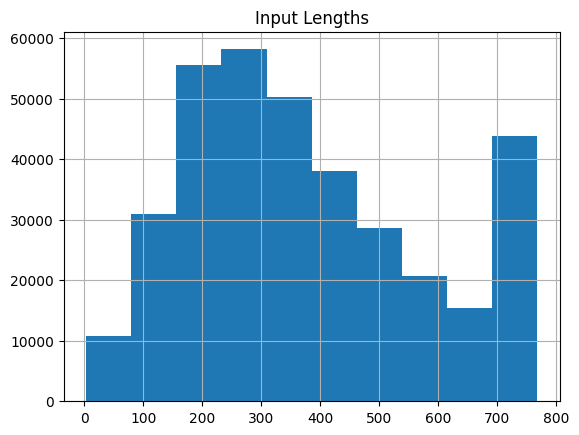

In [11]:
pd.DataFrame(CONFIG.max_seq_len - DATA.attn_masks.sum(axis=1), columns=["Input Lengths"]).hist()

In [12]:
print(Tokenizer.decode(DATA[0]["inputs"]))

[BOS]function transformExtremeEarHygiene(dryRun = false) {
  // Define variables
  let actionTaken = "";

  // Determine whether ear wax removal is necessary
  const needsRemoval = true;
  
  // If dry run is not requested, determine appropriate course of action 
  if (!dryRun && needsRemoval) {
    actionTaken = "Have patient use cotton swabs gently to remove excess ear wax";
  } else if (dryRun) {
    console.log("Dry Run: No action taken");
  } else {
    actionTaken = "No action needed - no evidence of ear wax buildup";
  }

  return `Action Taken: ${actionTaken}`;
}

// Call the function and print the result
console.log(transformExtremeEarHygiene());  // Action Taken: Have patient use cotton swabs gently to remove excess ear wax
console.log(transformExtremeEarHygiene(true)); // Dry Run: No action taken[EOS][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][P

In [13]:
print(Tokenizer.decode(DATA[0]["targets"]))

function transformExtremeEarHygiene(dryRun = false) {
  // Define variables
  let actionTaken = "";

  // Determine whether ear wax removal is necessary
  const needsRemoval = true;
  
  // If dry run is not requested, determine appropriate course of action 
  if (!dryRun && needsRemoval) {
    actionTaken = "Have patient use cotton swabs gently to remove excess ear wax";
  } else if (dryRun) {
    console.log("Dry Run: No action taken");
  } else {
    actionTaken = "No action needed - no evidence of ear wax buildup";
  }

  return `Action Taken: ${actionTaken}`;
}

// Call the function and print the result
console.log(transformExtremeEarHygiene());  // Action Taken: Have patient use cotton swabs gently to remove excess ear wax
console.log(transformExtremeEarHygiene(true)); // Dry Run: No action taken[EOS][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][P

In [14]:
DATA.save_to("./data/decoder_data.pt")